# Lab 7: The Transformer
### Description:
For this lab, you will fill in the attention mechanism for the Transformer architecture. 

There are three parts of this lab:
1. Implement scaled dot-product attention
2. Implement a multi-headed attention mechanism
3. Translate general conference!


### Grading standards

Your code will be graded on the following:

- 45% Implementation of scaled dot-product attention
- 45% Implementation of multi-headed attention mechanism
- 10% Reasonable translation of general conference

Note: This lab was adapted from "The Annotated Transformer", a publically available PyTorch implementation of the Transformer. This lab only requires about 20 lines of code, but we want you to think hard about the dimensions on which different operations apply, and debug accordingly. This will be trivial if you use the implementation for reference, but will be a worthwhile learning exercise if you don't. So we ask you not to reference that particular implementation, though you are free to reference other implementations (see references below).

    
### Tips:
A couple of tips for this lab:
1. The provided code instantiates the `MultiHeadedAttention` class for you. For a start, try printing the dimensions of `key`, `query`, and `values` in the `forward()` function of the `MultiHeadedAttention` class.
2. The key to this lab is section 3.2 of "Attention is All you Need". This section will tell you pretty much all you need to know about dimensions. https://arxiv.org/pdf/1706.03762.pdf
3. The queries, keys, and values come in the form N x L x d_model, where N is the batch size, L is the sentence length, and d_model is the dimension of the embedding. Both the batch size and the sentence length vary across training instances.
4. There are 3 pytorch implementations of matrix multiplication: torch.bmm, torch.mm, and torch.matmul. You'll want to figure out which one to use for this lab.
5. There are 3 pytorch implementations of transpose: torch.t, torch.transpose, and torch.permute. You'll want to figure out which one of those to use as well.
6. This implementation provides a `clone()` function that you may find useful in the MultiHeadedAttention class

### Example Output
An example of my final samples are shown below, after 3 epochs through the data. You should expect each epoch to take ~10 minutes, and should see reasonable results after the first epoch.

Spanish:	Muchos miembros de la Iglesia tuvieron fe en las profecías de Brigham Young , mientras que otros se mostraron escépticos y partieron hacia lo que ellos creían que sería una vida mejor . 

Translation:	Many members of the Church had faith in Brigham Young , while others who showed and other mocking to what they would be better than they would be better better than they would better . 

Target:		Many Church members had faith in Brigham Young ’s prophecies , while others remained <unk> and left for what they assumed would be a better life . 

## Original research papers

Based on "Attention is All You Need" (https://arxiv.org/abs/1706.03762) and "The Annotated Transformer" (https://nlp.seas.harvard.edu/2018/04/03/attention.html)
### Also useful:
http://jalammar.github.io/illustrated-transformer/

https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/


## Setup


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

# Download english and spanish vocab and general conference texts
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download es
!wget  -O ./spanish "https://raw.githubusercontent.com/nickwalton/translation/master/gc_2010-2017_conglomerated_20171009_es.txt"
!wget -O ./english "https://raw.githubusercontent.com/nickwalton/translation/master/gc_2010-2017_conglomerated_20171009_en.txt"

     |████████████████████████████████| 12.0 MB 25.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 16.2 MB 16.8 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=1f7a20821aee13361dd4772e35ad8c241bbd2c088026288006add4dcfef49dc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ltda9vsl/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/es
You can now load the model via spacy.l

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Model

## Model Helpers


In [3]:
class PositionwiseFeedForward(nn.Module):
    "Simple linear layers with dropout and relu"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class Embeddings(nn.Module):
    "Create word embeddings"
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
    
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

class LayerNorm(nn.Module):
    "Construct a layernorm module "
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
    
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## Encoder

The encoder is composed of a stack of $N=6$ identical layers. 

In [4]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## Decoder

The decoder is also composed of a stack of $N=6$ identical layers.  


In [5]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
    
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
    
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

##Implement Attention


https://arxiv.org/pdf/1706.03762.pdf         
                                                                                                                                                                     

### Personal implementation
Follows Peter Bloem's blog article: [Transformers from Scratch](http://peterbloem.nl/blog/transformers).

In [6]:
import torch
import torch.nn.functional as F

#### Basic self-attention

In [7]:
# input tensor, of shape: (batch_size, sequence_length, embedding_dimensions)
# In this case: batch size is 3, sequence length is 10 tokens, 
# and the embeddings have 512 dimensions

input_tensor = torch.rand(size=(3, 10, 512))

In [8]:
# Batch matrix multiply the input tensor by itself (transposed)
# torch.transpose swaps the two dimensions given, i.e., (1, 2) becomes (2, 1) in the output
# See: https://pytorch.org/docs/stable/generated/torch.transpose.html
raw_weights = torch.bmm(input_tensor, input_tensor.transpose(1, 2))
# print(raw_weights.size())
# >>> torch.Size([3, 10, 10])


# Next, softmax across the rows by applying softmax over the column dimension (2)
# See: https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html
weights = F.softmax(raw_weights, dim=2)
# print(weights.size())
# >>> torch.Size([3, 10, 10])

# Finally, multiply the weights by the input tensor, computing the dot product
# of each row of weights with each column (embedding dimension) of input_tensor
# and storing the results in a matrix the same size as input_tensor, since it
# will have num rows = rows in the weights tensor (i.e., dim 1, or 10) and 
# num columns = columns in the input_tensor (i.e., dim 2, or 512)
output_tensor = torch.bmm(weights, input_tensor)
print(output_tensor.size())
# >>> torch.Size([3, 10, 512])

torch.Size([3, 10, 512])


Demonstration of softmax function across the rows (representing the sequences), which is done by softmaxing over the columns (that is, the embeddings).

In [9]:
test_tensor = torch.rand(size=(3, 2, 4))
print('Input tensor')
print('Shape:', test_tensor.size())
print(test_tensor)

# Apply softmax to the rows (dimenion 1), by softmaxing over
# the columns (dimension 2)
test_softmax = F.softmax(test_tensor, dim=2)
print('\nSoftmax across dim 2 (third dimension)')
print('Shape:', test_softmax.size())
print(test_softmax)

# Show that the softmax was applied across the rows,
# because the values in each row sum to 1
print('\nSum across dim 2 (third dimension)')
print('Shape:', test_softmax.sum(dim=2).size())
print(test_softmax.sum(dim=2))

Input tensor
Shape: torch.Size([3, 2, 4])
tensor([[[0.5591, 0.9446, 0.2818, 0.7030],
         [0.2547, 0.3404, 0.9466, 0.1922]],

        [[0.9406, 0.6667, 0.6960, 0.6937],
         [0.2305, 0.1193, 0.1345, 0.7817]],

        [[0.5095, 0.5351, 0.0644, 0.9260],
         [0.9660, 0.5768, 0.5459, 0.3716]]])

Softmax across dim 2 (third dimension)
Shape: torch.Size([3, 2, 4])
tensor([[[0.2282, 0.3355, 0.1729, 0.2635],
         [0.1989, 0.2167, 0.3974, 0.1869]],

        [[0.3008, 0.2287, 0.2355, 0.2350],
         [0.2203, 0.1971, 0.2002, 0.3824]],

        [[0.2390, 0.2452, 0.1532, 0.3625],
         [0.3464, 0.2347, 0.2276, 0.1912]]])

Sum across dim 2 (third dimension)
Shape: torch.Size([3, 2])
tensor([[1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000]])


#### Self attention with queries, keys, and values

Implementation of Scaled Dot-product Attention in section 3.2.1 in the [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf) paper.

**Why scale by $\sqrt{embedding\_dimensions}$ ?**

According to [Peter Bloem's quick review of linear algebra concepts](http://peterbloem.nl/blog/pca#helpful-linear-algebra-properties), "The length of a vector is the square root of its dot product with itself." In Peter's other blog post, [Transformers from Scratch](http://peterbloem.nl/blog/transformers), section "Additional Tricks", bullet (2), he notes that the Euclidean length (i.e., length) of a vector of $k$ dimensions with values all $c$ will be $\sqrt{k}c$, so by dividing by $\sqrt{k}$, you divide out the amount by which the vector's dimensionality influences its length.

For example, a column vector with 4 dimensions (i.e., rows), each with a value of 2 would have a length of 4 (dot-product of vector with itself is 16, or 2×2×4). If you compute it as $\sqrt{k}c$, you get $\sqrt{4}×2 = 4$.

In [10]:
# Create weight matrices for the Queries, Keys, and Values
W_q = torch.rand(size=(512, 512))
W_k = torch.rand(size=(512, 512))
W_v = torch.rand(size=(512, 512))

# Matrix-multiply the weight matrices by the input tensor
# Q, K, and V are of same shape as the input tensor (torch.Size([3, 10, 512]))
Q = torch.matmul(input_tensor, W_q)
K = torch.matmul(input_tensor, W_k)
V = torch.matmul(input_tensor, W_v)

# Compute the attention output: a tensor of the same shape as
# the input, with columns (dim 2) used as the softmax dimension
# so the softmax occurs across the rows.
# softmax((Q * K_transposed) / (sqrt(embedding_dimensions))) * V

raw_weights = torch.matmul(Q, K.transpose(1, 2))
scaled_raw_weights = raw_weights / (Q.size()[2] ** (1/2))
weights = F.softmax(scaled_raw_weights, dim=2)
attn_output = torch.matmul(weights, V)

# Alternatively, you can perform all at once:
# attn_output = torch.matmul(
#     F.softmax(
#             torch.matmul(Q, K.transpose(1, 2)) 
#             / (Q.size()[2] ** (1/2))
#         , dim=2)
#     , V)

print(attn_output.size())
# >>> torch.Size([3, 10, 512])

torch.Size([3, 10, 512])


#### Multi-head version

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class SelfAttention(nn.Module):
    # Create class constructor
    def __init__(self, k, heads=8):
        # Inherit from the nn.Module class
        super().__init__()
        # k = embedding_dimensions used throughout the network
        self.k, self.heads = k, heads

        # Compute 3 matrices: one each for queries, keys, and values
        # Each matrix is a (k, h×k) matrix, so the matrices for each head are
        # concatenated together into one wide matrix for single-step mat-multiply

        # Output size: (b, t, h*k)
        self.tokeys = nn.Linear(k, k * heads, bias=False)
        self.toqueries = nn.Linear(k, k * heads, bias=False)
        self.tovalues = nn.Linear(k, k * heads, bias=False)

        # Unify outputs to a single tensor with k-dimensions
        # That is, take as input size (k * heads) and return as output k
        self.unifyheads = nn.Linear(k * heads, k)


    # Implement self attention
    def forward(self, x):
        # b=batch_size, t=sequence_length, k=embedding_dimensions
        b, t, k = x.size()
        h = self.heads
        queries = self.toqueries(x).view(b, t, h, k)
        keys = self.tokeys(x).view(b, t, h, k)
        values = self.tovalues(x).view(b, t, h, k)

        # Move heads to batch dimension to process together
        # First, transpose to swap the (t, h) dimensions
        # Next, return a view that combines the b and h dimensions.

        # Why use .contiguous()? It returns a copy of the tensor after
        # being transposed.
        # See: https://stackoverflow.com/a/52229694/17005348
        queries = queries.transpose(1, 2).contiguous().view(b*h, t, k)
        keys = keys.transpose(1, 2).contiguous().view(b*h, t, k)
        values = values.transpose(1, 2).contiguous().view(b*h, t, k)

        # Scale queries and keys matrices by ((embedding_dim) ** 1/4)
        # To save computation if the sequences are large. Since the queries
        # and keys matrices will be multiplied together, this has the same
        # effect as multiplying them first and then dividing by ((emb_dim) ** (1/2)
        # because (x**1/4) * (x**1/4) = x**1/2
        queries = queries / (k ** (1/4))
        keys = keys / (k ** (1/4))

        raw_weights = torch.bmm(queries, keys.transpose(1,2))
        # print(raw_weights.size())
        # >>> torch.Size([b * h, t, t])

        weights = F.softmax(raw_weights, dim=2)
        # print(weights.size())
        # >>> torch.Size([b * h, t, t])

        # Multiply weights by the values matrix,
        # then return a view that separates heads from batch
        output = torch.bmm(weights, values).view(b, h, t, k)

        # Return the output to the standard form of (b, t, h*k)
        output = output.transpose(1, 2).contiguous().view(b, t, h*k)
        
        # Combine outputs of all heads and return new embedding
        return self.unifyheads(output)


In [13]:
# input tensor, of shape: (batch_size, sequence_length, embedding_dimensions)
# In this case: batch size is 3, sequence length is 10 tokens, 
# and the embeddings have 512 dimensions

input_tensor = torch.rand(size=(3, 10, 512))
print('Input tensor shape:', input_tensor.size())

k_dim = input_tensor.size()[2]

attn = SelfAttention(k=k_dim, heads=8)

new_embeddings = attn(input_tensor)
print('Output tensor shape:', new_embeddings.size())

Input tensor shape: torch.Size([3, 10, 512])
Output tensor shape: torch.Size([3, 10, 512])


### Implementation for the lab

In [14]:
# In the function below, query, key, and value are all
# tensors of shape: (batch_size, sequence_length, embedding_dimensions).
# When performing matrix multiplication, the matrices are multipled
# along the embedding axis. See: https://youtu.be/EBMrh7hN9T0?t=514

# Also, there are no layers or parameters, this is just a function. The
# learning happens in the weight matrices that are used to create the 
# queries, keys, and values.

def attention(query, key, value, mask):
    # Compute 'Scaled Dot Product Attention'
    embedding_size = query.size()[2]
    
    # scores = (Q * K_transposed) / scale
    # scores.size() --> (batch_size, sequence_length, sequence_length)
    scores = torch.matmul(query, key.transpose(1,2)) / (embedding_size ** (1/2))

    # Apply the mask
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        
    # output = softmax(scores)*(V)
    # Apply softmax across the sequence dimension (dim 1, the rows, or second dimension)
    # by softmaxing over the embedding dimension (dim 2, the columns, or third dimension)
    output = torch.matmul(F.softmax(scores, dim=2), value)

    return output

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        '''
        h = number of self-attention heads
        d_model = the number of dimensions in the embedding, 
            which is the same throughout the model (e.g., 512)
        '''
        # Implement Multi-head attention mechanism
        # Make an attention head (linear layers for q, k, and v)
        # Make h copies of the attention head
        # (Hint: See the `clones(nn.Module, num_clones)` helper function)
        # etc. ...
        super().__init__()
        self.dropout = dropout
        self.heads = h
        self.embedding_dims = d_model
        # weights_dim reduces computational expense by adjusting the size
        # of the weight matrices for Q, K, and V, which in turn reduces
        # the embedding dimension (after matrix multiplication with input)
        self.weights_dim = int(d_model // h)
        if (self.weights_dim * h) != d_model:
            raise TypeError(f"The model's embedding dimensions (d_model={d_model}) cannot be evenly divided by the chosen number of heads (h={h})."
            + "\nThe number of heads must divide evenly into the embedding dimension to reduce the size of the queries, keys, and values weight matrices.")

        # Output shape: (b, t, w)
        # where b = batch, t = sequence_length, and w = weights_dim)
        self.query_heads = clones(nn.Linear(self.embedding_dims, self.weights_dim, bias=False), self.heads)
        self.key_heads = clones(nn.Linear(self.embedding_dims, self.weights_dim, bias=False), self.heads)
        self.value_heads = clones(nn.Linear(self.embedding_dims, self.weights_dim, bias=False), self.heads)

        # Combine outputs of all attention heads
        # That is, take as input size (weights_dim * heads) and return as output embedding_dims
        self.final_output = nn.Linear(self.weights_dim * self.heads, self.embedding_dims)

    def forward(self, query, key, value, mask):
        '''
        Pass input through multi-head attention and return new embeddings
        '''
        # For each attention head
            # Pass the query, key, value through their respective layers
            # Compute scaled dot-product attention on the output
        # etc.

        # Understand model input dimensions
        # print(f'Query dimensions: {query.size()}'
        # + f'\nKey dimensions: {key.size()}'
        # + f'\nValue dimensions: {value.size()}'
        # + f'\nMask dimensions: {mask.size()}')

        # Output examples:
        # Query dimensions: torch.Size([26, 34, 256])
        # Key dimensions: torch.Size([26, 34, 256])
        # Value dimensions: torch.Size([26, 34, 256])
        # Mask dimensions: torch.Size([26, 1, 34])

        # Query dimensions: torch.Size([26, 37, 256])
        # Key dimensions: torch.Size([26, 37, 256])
        # Value dimensions: torch.Size([26, 37, 256])
        # Mask dimensions: torch.Size([26, 37, 37])

        # Query dimensions: torch.Size([26, 37, 256])
        # Key dimensions: torch.Size([26, 34, 256])
        # Value dimensions: torch.Size([26, 34, 256])
        # Mask dimensions: torch.Size([26, 1, 34])

        # Store outputs of all heads in a list
        queries = []
        keys = []
        values = []
        outputs = []

        # Pass the queries, keys, and values through linear layers
        for q_head in self.query_heads:
            queries.append(q_head(query))
        
        for k_head in self.key_heads:
            keys.append(k_head(key))

        for v_head in self.value_heads:
            values.append(v_head(value))

        # Compute self-attention on each head for queries, keys, and values
        for head_num in range(self.heads):
            outputs.append(
                attention(
                    queries[head_num],
                    keys[head_num],
                    values[head_num],
                    mask)
                )
        
        # Concatenate outputs along embedding dimension
        output = torch.cat(outputs, dim=2)

        # Pass output through final linear layer
        output = self.final_output(output)

        # Apply dropout (see section 5.4 of Attention is All You Need paper)
        output = F.dropout(output, p=self.dropout) 

        # return new embeddings
        return output

## Positional Encoding                                                                                                                             
Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](https://arxiv.org/pdf/1705.03122.pdf). 

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$. 
                                                                                                                                                                                                                                                    


In [16]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = 1 / (10000 ** (torch.arange(0., d_model, 2) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

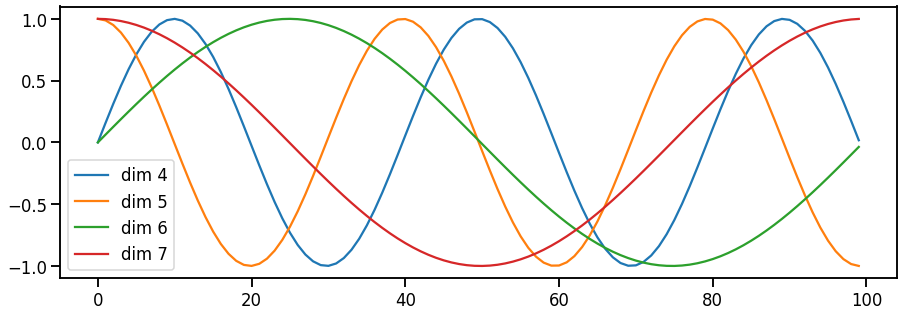

In [17]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend([f'dim {p:d}' for p in [4,5,6,7]])
plt.show();

## Full Model

In [18]:
class TransformerModel(nn.Module):
    """
    Full transformer model
    """
    def __init__(self, src_vocab, tgt_vocab, N=6, d_model=256, d_ff=1024, h=8, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        attn = MultiHeadedAttention(h, d_model)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        position = PositionalEncoding(d_model, dropout)
        c = copy.deepcopy
        
        self.encoder = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
        self.decoder = Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N)
        self.src_embed = nn.Sequential(Embeddings(d_model, src_vocab), c(position))
        self.tgt_embed = nn.Sequential(Embeddings(d_model, tgt_vocab), c(position))
        self.generator = Generator(d_model, tgt_vocab)
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

# Training


## Batches and Masking

In [19]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
    
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).  This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.  

In [20]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

## Data Loading


In [21]:
# torchtext.legacy, see: https://github.com/pytorch/text/releases/tag/v0.9.0-rc5
from torchtext.legacy import data, datasets
import torchtext
import spacy

# Load spacy tokenizers.
spacy_es = spacy.load('es')
spacy_en = spacy.load('en')

def tokenize_es(text):
    return [tok.text for tok in spacy_es.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field(tokenize=tokenize_es, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                 eos_token = EOS_WORD, pad_token=BLANK_WORD)

print("Loading Dataset")
spanish_text = open('./spanish','r')
english_text = open('./english', 'r')
english_lines = list(english_text)
spanish_lines = list(spanish_text)

fields = (["src", SRC], ["trg", TGT])
examples = [torchtext.legacy.data.Example.fromlist((spanish_lines[i], english_lines[i]), fields ) for i in range(len(english_lines))]

MAX_LEN = 200
train, val = torchtext.legacy.data.Dataset(examples, fields=fields, filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
        len(vars(x)['trg']) <= MAX_LEN).split()

MIN_FREQ = 1
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)
print('Finished loading dataset')

Loading Dataset
Finished loading dataset


## Training Code

In [22]:
from tqdm.notebook import tqdm

class LossFunction:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.zero_grad()
        return loss.data * norm

class DataIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1).to(device), batch.trg.transpose(0, 1).to(device)
    return Batch(src, trg, pad_idx)

    
def run_epoch(data_iter, model, loss_compute):
    # progressbar = tqdm(total=len(data_iter))

    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        # progressbar.set_description(f'Epoch progress: {i+1}/{len(data_iter)}')
        # progressbar.update(n=1)
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens
    

##Train

In [23]:
import gc
gc.collect()

pad_idx = TGT.vocab.stoi["<blank>"]
model = TransformerModel(len(SRC.vocab), len(TGT.vocab), N=2).to(device)
n_epochs = 3

def scope():
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.to(device)
    BATCH_SIZE = 1000
    train_iter = DataIterator(train, batch_size=BATCH_SIZE, device=device,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = DataIterator(val, batch_size=BATCH_SIZE, device=device,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)

    model_opt = torch.optim.Adam(model.parameters(), lr=5e-4)
    for epoch in range(n_epochs):
        model.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model, 
                  LossFunction(model.generator, criterion, model_opt))
        model.eval()
scope()

Epoch Step: 1 Loss: 8.674969 Tokens per Sec: 2555.479248
Epoch Step: 51 Loss: 5.831997 Tokens per Sec: 9901.856445
Epoch Step: 101 Loss: 5.424524 Tokens per Sec: 10196.914062
Epoch Step: 151 Loss: 5.406699 Tokens per Sec: 10257.004883
Epoch Step: 201 Loss: 5.063268 Tokens per Sec: 10091.420898
Epoch Step: 251 Loss: 5.277559 Tokens per Sec: 6200.183594
Epoch Step: 301 Loss: 4.517795 Tokens per Sec: 10209.135742
Epoch Step: 351 Loss: 5.539042 Tokens per Sec: 9746.866211
Epoch Step: 401 Loss: 4.788088 Tokens per Sec: 9639.072266
Epoch Step: 451 Loss: 4.476522 Tokens per Sec: 10047.947266
Epoch Step: 501 Loss: 4.588769 Tokens per Sec: 10065.587891
Epoch Step: 551 Loss: 4.492024 Tokens per Sec: 10090.831055
Epoch Step: 601 Loss: 4.741349 Tokens per Sec: 10042.531250
Epoch Step: 651 Loss: 3.210069 Tokens per Sec: 10201.685547
Epoch Step: 701 Loss: 4.901657 Tokens per Sec: 9986.680664
Epoch Step: 751 Loss: 3.995470 Tokens per Sec: 10261.557617
Epoch Step: 801 Loss: 4.322822 Tokens per Sec: 10

In [26]:
!nvidia-smi

Fri Feb 25 21:36:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   3530MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Translate

In [27]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

BATCH_SIZE = 1000
n_train_iters = len(train) / BATCH_SIZE
valid_iter = DataIterator(val, batch_size=BATCH_SIZE, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)
    
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1].to(device)
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).to(device)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Spanish:", end="\t")
    for i in range(0, src.size(1)):
        sym = SRC.vocab.itos[src[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:\t", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print()
    
    if i > 1000 and i<1100:
        break

Spanish:	El nuevo mandamiento 
Translation:	The new commandment 
Target:		The New Commandment 

Spanish:	Todos somos líderes 
Translation:	We Are All Leaders 
Target:		We Are All Leaders 

Spanish:	Guíenme ; enséñenme 
Translation:	I ’ll love me . 
Target:		Lead me , guide me , walk beside me , 

Spanish:	El servicio cristiano . 
Translation:	Service . 
Target:		Christian service . 

Spanish:	Élder Gerrit W. Gong 
Translation:	Elder Gong 
Target:		Elder Gerrit W. Gong 

Spanish:	Véase Apocalipsis 7:17 . 
Translation:	See Revelation 7:17 . 
Target:		See Revelation 7:17 . 

Spanish:	Podemos sanar espiritualmente . 
Translation:	We can spiritually spiritually spiritually spiritually . 
Target:		We can heal spiritually . 

Spanish:	Me sentía <unk> . 
Translation:	I felt that I was mindful of . 
Target:		That was exactly the wrong thing to do . I felt helpless . 

Spanish:	01 de octubre de 2016 
Translation:	October 2016 
Target:		October 01 , 2016 

Spanish:	Doctrina y Convenios 11:20 . 
T

<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>